# Loan Prediction


# Cargar librerías y funciones

In [1]:
import numpy as np   
import pandas as pd 

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns     

#Para leer los datos desde Google Colab
from google.colab import files  

#funciones específicas de Sckit-learn 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
#para exportar el gráfico como archivo.dot
from sklearn.tree import export_graphviz  

#para visualizar el arbol desde el formato .dot
from IPython.display import Image
from pydotplus import graph_from_dot_data


###correlacion()

In [2]:
def correlacion(dataframe, grafica=True, matrix=False):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()                   
    if grafica==True:
      fig = plt.figure(figsize = (25, 20))
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm", 
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(), 
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

### grafica_roc

In [3]:
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)  
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()



# 1. Lectura de datos y breve exploración

Cargar los datos en colab, utilizando la función 
files.upload()

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/ClasificadorClientesTelecom/master/Datos/Loan%20Prection.csv')

df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [5]:
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
#Ver valores únicos de cada variable
df.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

## 2. Preprocesamiento


### Se eliminan las variables innecesarias


Una vez que se han guardado en una variable aparte los IDs de los clientes, se
procede a borrarlos del Data Frame

In [7]:
Loan_ID = df['Loan_ID']

df = df.drop('Loan_ID', axis=1)

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Transformación de variables y manejo de valores nulos

In [8]:
#Convertimos TotalCharges a numérica.
#Revisar para que se utiliza errors='coerce'

df['ApplicantIncome'] =pd.to_numeric(df['ApplicantIncome'], errors='coerce')
df['CoapplicantIncome'] =pd.to_numeric(df['CoapplicantIncome'], errors='coerce')
df['LoanAmount'] =pd.to_numeric(df['LoanAmount'], errors='coerce')  # Deberíamos eliminar los renglones donde no hay info de LoanAmount?

In [12]:
#¿Cuántos valores nulos quedaron?

print(df['LoanAmount'].isnull().sum())

df[df['LoanAmount'].isnull()].head()

0


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [10]:
#Remplazamos por 0 los valores nulos 
df = df.fillna(value=0)

### Binarización de variables

In [20]:
#Revisamos las categorías y frecuencias de cada variable de tipo "objeto"

df_obj = df.select_dtypes("object",)  

for col in df_obj.columns:
    print (col)
    print (df[col].value_counts(),'\n')

Dependents
0     345
1     102
2     101
3+     51
0      15
Name: Dependents, dtype: int64 

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64 



In [13]:
yes_no_columns = [
                  'Married','Self_Employed'
                  ]

# I'm making here the No = 0, assuming no data = Not Married, no data = Self_Employed

for i in yes_no_columns:
    df[i].replace(to_replace='Yes', 
                  value=1, inplace=True)
    df[i].replace(to_replace='No', 
                  value=0, inplace=True)
df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,0,0,Graduate,0,5849,0.0,0.0,360.0,1.0,Urban,Y
1,Male,1,1,Graduate,0,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,1,0,Graduate,1,3000,0.0,66.0,360.0,1.0,Urban,Y


In [15]:
y_n_columns = [
                  'Loan_Status'
                  ]

# I'm making here the No = 0, assuming no data = Not Married, no data = Self_Employed

for i in y_n_columns:
    df[i].replace(to_replace='Y', 
                  value=1, inplace=True)
    df[i].replace(to_replace='N', 
                  value=0, inplace=True)
df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,0,0,Graduate,0,5849,0.0,0.0,360.0,1.0,Urban,1
1,Male,1,1,Graduate,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,1,0,Graduate,1,3000,0.0,66.0,360.0,1.0,Urban,1


In [17]:
# Make no data = Male

gender_column = [
                  'Gender'
                  ]

for i in gender_column:
    df[i].replace(to_replace='Female', 
                  value=1, inplace=True)
    df[i].replace(to_replace='Male', 
                  value=0, inplace=True)
df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,Graduate,0,5849,0.0,0.0,360.0,1.0,Urban,1
1,0,1,1,Graduate,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,0,1,0,Graduate,1,3000,0.0,66.0,360.0,1.0,Urban,1


In [19]:
# Make Graduate = 1

graduate_column = [
                  'Education'
                  ]

for i in graduate_column:
    df[i].replace(to_replace='Graduate', 
                  value=1, inplace=True)
    df[i].replace(to_replace='Not Graduate', 
                  value=0, inplace=True)
df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,1,0,5849,0.0,0.0,360.0,1.0,Urban,1
1,0,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,0,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1


In [24]:
print(df.shape)
print(df.columns)

(614, 18)
Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Loan_Status', 'Dependents_0', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')


In [22]:
#Utilizamos one-hot encoding para convertir variables categoricos a binarias (con ceros y unos)
df = pd.get_dummies(df)

print(df.shape, '\n', df.columns)

(614, 18) 
 Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Loan_Status', 'Dependents_0', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')


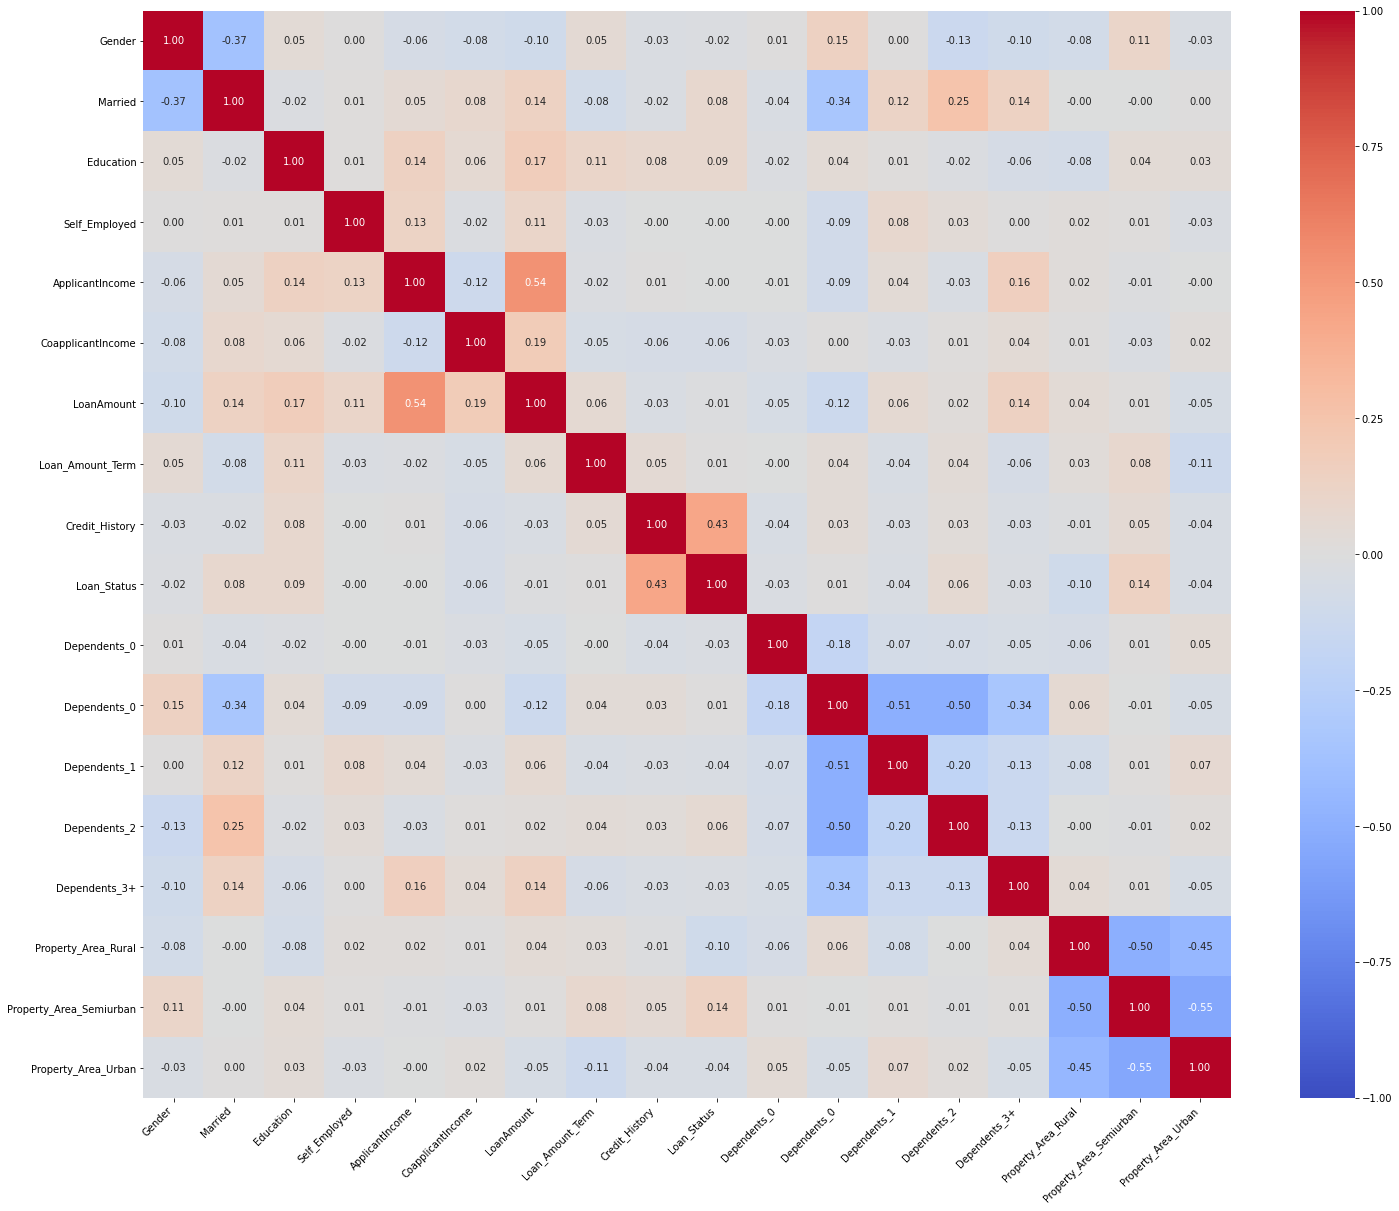

In [23]:
#Detectar variables redundantes 

corr_matrix=correlacion(df, grafica=True, matrix=True)

In [25]:
#Identificar variables redundantes 

# Triangulo superior de la matriz de correlación en números absolutos
triangulo_sup = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape),
                                                1).astype(np.bool))

# Encontrar las columnas donde la correlación es 1
borrar = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] == 1)]

borrar

['Dependents_0', 'Dependents_0']

In [26]:
#eliminar columnas en la lista borrar
df = df.drop(columns = borrar)

In [27]:
print('Número de columnas: ', df.shape[1], '\n') 
print('Número de valores en cada columna: ')
df.nunique()

Número de columnas:  16 

Número de valores en cada columna: 


Gender                       2
Married                      2
Education                    2
Self_Employed                2
ApplicantIncome            505
CoapplicantIncome          287
LoanAmount                 204
Loan_Amount_Term            11
Credit_History               2
Loan_Status                  2
Dependents_1                 2
Dependents_2                 2
Dependents_3+                2
Property_Area_Rural          2
Property_Area_Semiurban      2
Property_Area_Urban          2
dtype: int64

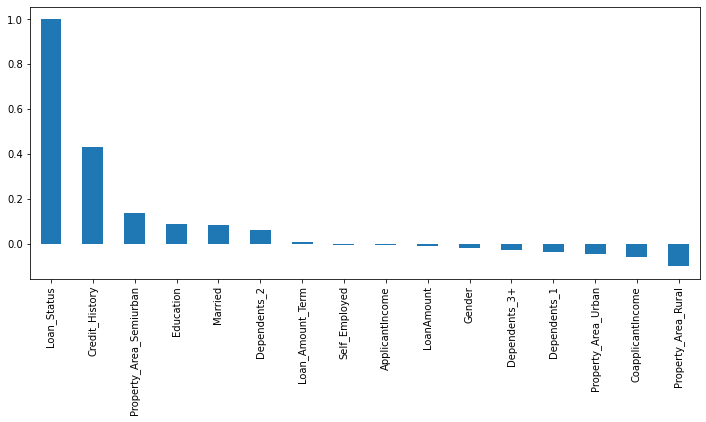

In [29]:
#Correlación de cada variable con Churn
plt.figure(figsize = (12,5))
df.corr()['Loan_Status'].sort_values(ascending = False).plot(kind ='bar',)

# Árbol de Decisión

## Creación de subconjuntos de entrenamiento y prueba 

In [30]:
#Separar las etiquetas del conjunto de datos

Z = df['Loan_Status']
X = df.drop('Loan_Status', axis=1)

In [31]:
X_train, X_test, Z_train, Z_test = train_test_split(X, Z,
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=261)


In [32]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("TRAINING SET")
print("X: ", X_train.shape)
print("Z: ", Z_train.shape)
print('Clientes con crédito aprobado:{:7.3f}%'.format(Z_train.mean()*100),'\n')

print("TEST SET")
print("X: ", X_test.shape)
print("Z: ", Z_test.shape)
print('Clientes con crédito aprobado:{:7.3f}%'.format(Z_test.mean()*100))

TRAINING SET
X:  (429, 15)
Z:  (429,)
Clientes con crédito aprobado: 69.930% 

TEST SET
X:  (185, 15)
Z:  (185,)
Clientes con crédito aprobado: 65.946%


## Entrenamiento y prueba del modelo

In [33]:
profundidad = None

#Entrenamiento del modelo
clasificador = DecisionTreeClassifier( max_depth=profundidad,
                                      criterion="entropy", 
                                      random_state=0).fit(X_train, Z_train)

print("La profundida del árbol es: {}".format(clasificador.get_depth()))                          

#Predicción y evaluación sobre el conjunto de entrenamiento
Z_pred_train = clasificador.predict(X_train)
precision_train = accuracy_score(Z_train, Z_pred_train)*100
print("Precisión conjunto de entrenamiento: {:4.2f}%".format(precision_train))

#Predicción y evaluación sobre el conjunto de prueba
Z_pred_test = clasificador.predict(X_test)
precision_test = accuracy_score(Z_test, Z_pred_test)*100
print("Precisión conjunto de prueba: {:4.2f}%".format(precision_test),'\n')


La profundida del árbol es: 17
Precisión conjunto de entrenamiento: 100.00%
Precisión conjunto de prueba: 61.08% 



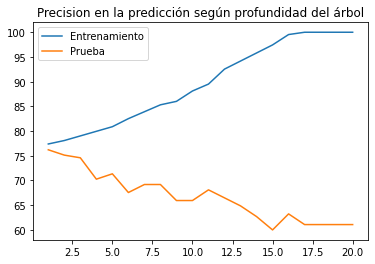

In [34]:
#Entrenamiento y prueba del modelo con distintos niveles de profunidad

clf = {}
Z_pred_train = {}
Z_pred_test = {}
precision_train={}
precision_test = {}

for p in range(1,21):
  #Entrenamiento del modelo
  clf[p] = DecisionTreeClassifier(max_depth = p,
                               criterion = "entropy",
                               min_samples_split = 2, 
                               random_state = 0).fit(X_train, Z_train)                        

  #Predicción y evaluación sobre el conjunto de entrenamiento
  Z_pred_train[p] = clf[p].predict(X_train)
  precision_train[p] = accuracy_score(Z_train, Z_pred_train[p])*100

  #Predicción y evaluación sobre el conjunto de prueba
  Z_pred_test[p] = clf[p].predict(X_test)
  precision_test[p] = accuracy_score(Z_test, Z_pred_test[p])*100

precision = pd.DataFrame( {'Entrenamiento':precision_train,
                           'Prueba': precision_test})

precision.plot.line(
    title ='Precision en la predicción según profundidad del árbol')
plt.show()

## Visualización del árbol de decisión

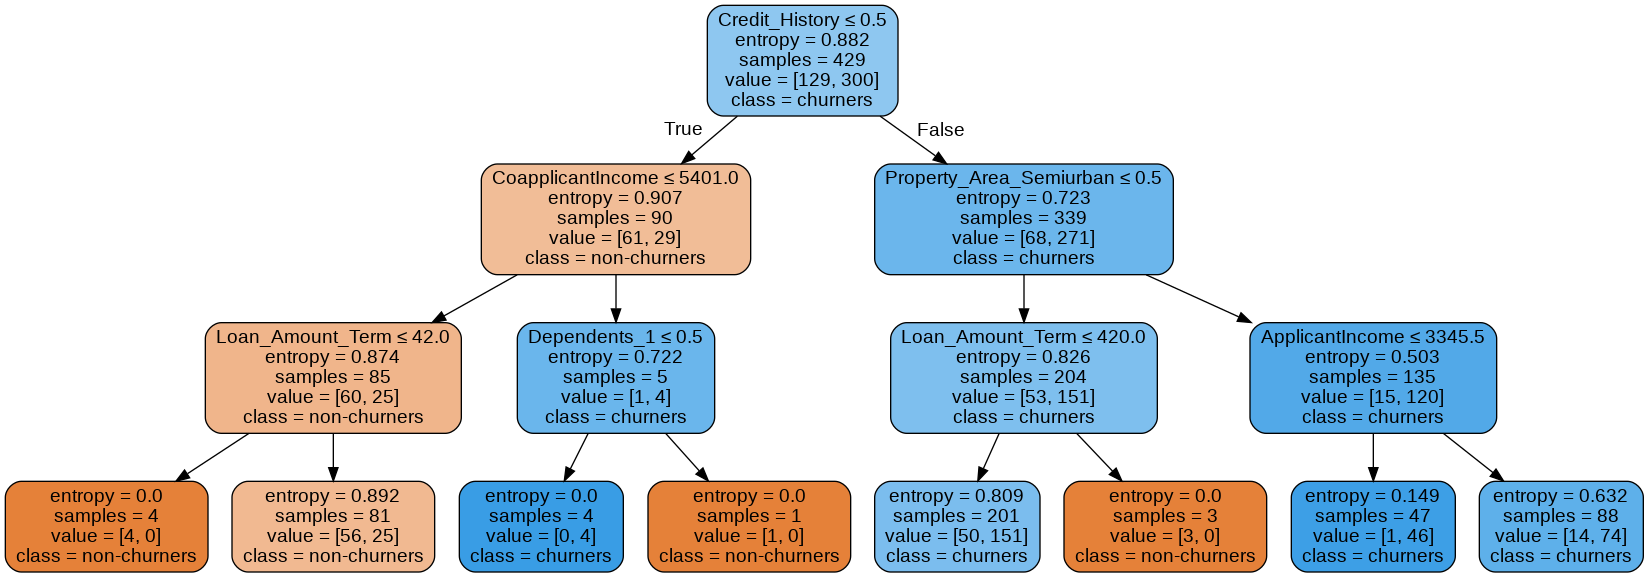

In [35]:
#Método 1 para graficar el arbol exportando el arbol como un archivo .dot

dot_data = export_graphviz(clf[3], rounded = True, 
                           filled = True, 
                           special_characters = True, 
                           feature_names = X.columns,
                           max_depth = 3,
                           class_names = ['non-churners','churners'])

graph = graph_from_dot_data(dot_data)

Image(graph.create_png())

## Importancia de cada variable de acuerdo al modelo

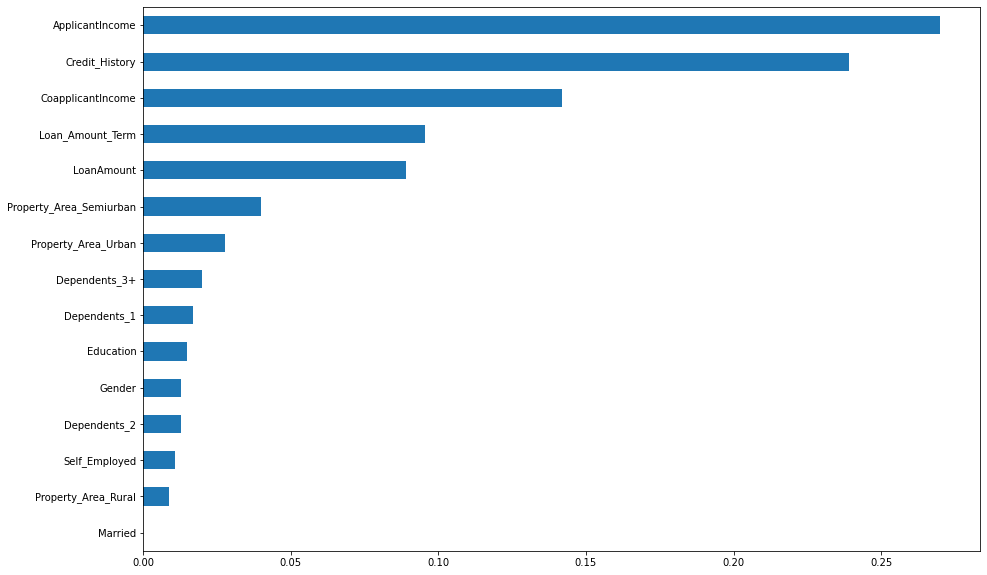

In [36]:
weights = pd.Series(clf[10].feature_importances_,
                    index=X.columns.values)

weights.sort_values().plot(kind = 'barh',figsize=(15, 10))

## Evaluació del modelo Matriz de confusión

**Matriz de confusión**

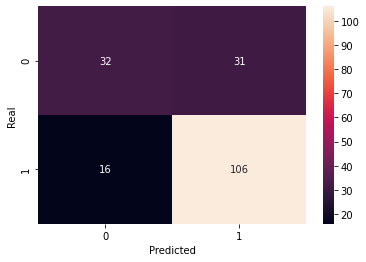

In [37]:
#Matriz de confusión

import seaborn as sns

data = {'Z_Real':  Z_test,
        'Z_Prediccion': Z_pred_test[3]
        }

df = pd.DataFrame(data, columns=['Z_Real','Z_Prediccion'])
confusion_matrix = pd.crosstab(df['Z_Real'], df['Z_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()


**[Curva ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)**

* eje x ----  Specificity (proporción de falsos positivos (*fpr*) )
* eje y ----  Recall/Sensitivity (proporción de verdaderos positivos (*tpr*))



In [38]:
print(clasificador.predict_proba( X_test))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 

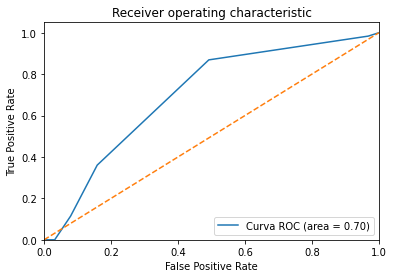

In [39]:
grafica_roc(clf[3], Z_test)


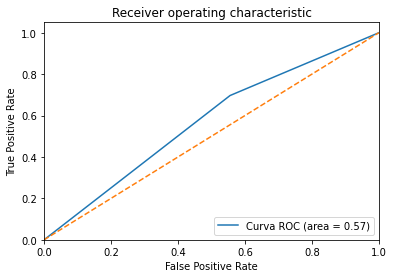

In [40]:
grafica_roc(clf[20], Z_test)

# Bosque Aleatorio

## Entrenamiento y prueba


In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
clf_rf = RandomForestClassifier(random_state =0, 
                                criterion='entropy', 
                                min_samples_split=5, n_estimators=100).fit(X_train, Z_train)


Z_pred = clf_rf.predict(X_test)
print("Precisión del modelo Bosque Aleatorio en el conjunto de prueba: {:4.2f}%".format(accuracy_score(Z_test, Z_pred)*100))


Precisión del modelo Bosque Aleatorio en el conjunto de prueba: 70.27%


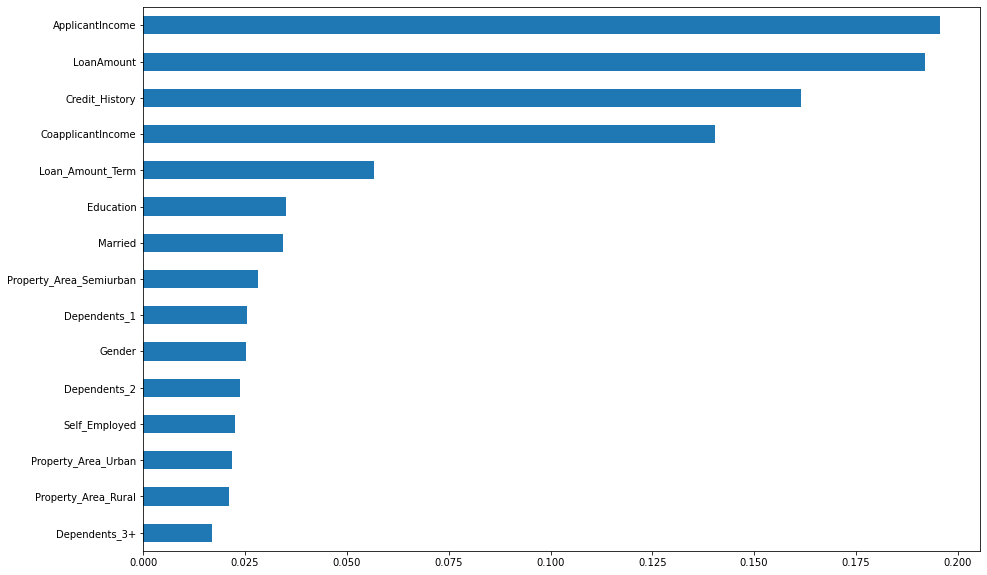

In [43]:
importances = clf_rf.feature_importances_
weights = pd.Series(importances,
                    index=X.columns.values)
weights.sort_values().plot(kind = 'barh',figsize=(15, 10))